# Implementation of VZ, RZ, and Hadamard Gates on a Transmon of $n=3$ levels

Our model of the transmon is the Standard Nonlinear Oscillator (SNO) or Duffing Oscillator, which is a cosine potential.

We have $\omega_0 = \sqrt{8 E_c E_J}$, and $\delta = -E_c$ as the transmon anharmonicity. Defining $\omega \equiv \omega_0+\delta$, we see that the transmon levels have energy spacings that each differ by the anharmonicity, as $\omega_{j+1}-\omega_j = \omega + \delta j$, so that $\omega$ corresponds to "the frequency" of the transmon qubit (the transition $\omega_1-\omega_0$). From the definition of the transmon operator, $\hat{c}^\dagger \hat{c} = \sum_j j |j\rangle \langle j|$, we arrive at
$$
\hat{H}_{\rm tr} = \omega \hat{c}^\dagger \hat{c} + \frac{\delta}{2} \hat{c}^\dagger \hat{c} (\hat{c}^\dagger \hat{c} - 1)
 = \sum_j \left(\left(\omega-\frac{\delta}{2}\right)j + \frac{\delta}{2} j^2\right) |j\rangle\langle j| \equiv \sum_j \omega_j |j\rangle \langle j|
$$
so that
$$
\omega_j = \left(\omega-\frac{\delta}{2}\right)j + \frac{\delta}{2} j^2
$$
are the energy levels of the transmon.

We add a drive term (in the qubit subspace this is a pauli X term) that couples adjacent energy levels (assuming higher order coupling is negligible) to perform our pulses. It takes the form
$$
\hat{H}_{\rm dr} = \frac{r \Omega(t)}{2} (\hat{c} + \hat{c}^\dagger)
$$ 
where $r$ is the drive strength and $\Omega(t)$ is the drive signal. Thus our full hamiltonian is
$$
\hat{H} = \hat{H}_{\rm tr} + \hat{H}_{\rm dr} = \omega \hat{c}^\dagger \hat{c} + \frac{\delta}{2} \hat{c}^\dagger \hat{c} (\hat{c}^\dagger \hat{c} - 1) + \frac{r \Omega(t)}{2} (\hat{c} + \hat{c}^\dagger)
$$

### RX Gate

Here we implement a single qubit RX gate with a three level system using a DRAG (derivative removal by adiabatic gate) pulse. Qubit frequency, anharmonicity, and gate time taken from IBM_sherbrooke qubit 74. $sigma$ of the pulse is 1/4 of the pulse duration, by convention. Optimization of the DRAG pulse amplitude can be done with JAX jit compilation or standard scipy scalar function minimization.

In [1]:
import numpy as np
import qiskit.pulse as pulse
from matplotlib import pyplot as plt
from qiskit_dynamics.pulse import InstructionToSignals
from qiskit.quantum_info.operators import Operator
from qiskit_dynamics import Solver, Signal
from matplotlib import pyplot as plt
from qiskit.quantum_info.states import Statevector
from scipy.optimize import minimize, minimize_scalar
import sympy as sym
import jax
jax.config.update("jax_enable_x64", True)

# tell JAX we are using CPU
jax.config.update('jax_platform_name', 'cpu')

import jax.numpy as jnp
from jax import jit, value_and_grad

For the standard nonlinear oscillator first order DRAG pulse, $\beta = -\frac{\lambda_1^2}{4\delta} = \frac{1}{2\delta}$ where $\lambda_1 = \sqrt{2}$ is the 1-2 relative coupling and $\delta$ is the anharmonicity.

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel='ibm_quantum', instance="ibm-q/open/main")
backend = service.backend("ibm_sherbrooke")

qubit_num = 74

w = backend.qubit_properties(qubit_num).frequency * 1E-9 #GHz, qubit frequency
dt = backend.dt * 1E9 #ns, AWG sample time
dur = int(backend.target["sx"][(qubit_num,)].duration * 1E9 / dt) #dt, single gate pulse duration
σ = dur / 4 #convention that duration is 4 sigma
n = 3 #3 level system
d = backend.qubit_properties(qubit_num).anharmonicity * 1E-9 #GHz, anharmonicity
b = - 1 / (2 * d) #ns, DRAG derivative strength
r = 0.1 #GHz, rabi frequency 

w, dt, dur, σ, d, b

(4.814375767212438,
 0.2222222222222222,
 256,
 64.0,
 -0.3112979024360073,
 1.6061785064638645)

Single transmon model class

In [80]:
class Transmon:
    def __init__(self, qubit_freq, anharmonicity, rabi_strength, pulse_duration, dt, compute_SX_X_gates = True):
        self.w = qubit_freq #GHz
        self.d = anharmonicity #GHz
        self.r = rabi_strength #GHz
        self.dur = pulse_duration #units of dt
        self.β = - 1 / (2 * self.d) #ns
        self.σ = self.dur / 4 #dt
        self.dt = dt #ns
        n = 3 #3 level model

        # construct the solver
        self.hamiltonian_solver = Solver(
            static_hamiltonian=Operator(Transmon.H_transmon(n, self.w, self.d)),
            hamiltonian_operators=[Operator(Transmon.H_drive(n, self.r))],
            rotating_frame=Operator(Transmon.H_transmon(n, self.w, self.d)),
            rwa_carrier_freqs=[self.w],
            #rwa_cutoff_freq=2 * self.w,
            array_library='jax',
            hamiltonian_channels=['d0'],
            channel_carrier_freqs={'d0': self.w},
            dt= self.dt
        )
        if compute_SX_X_gates:
            self.SX_results = minimize_scalar(self.single_transmon_objective, args=(np.pi/2), bounds=(0.,1.))
            with pulse.build(name="SX") as self.SX_pulse:
                pulse.play(self.drag([self.SX_results.x.item(), self.σ, self.β, self.dur]), pulse.DriveChannel(0))
            self.X_results = minimize_scalar(self.single_transmon_objective, args=(np.pi), bounds=(0.,1.))
            with pulse.build(name="X") as self.X_pulse:
                pulse.play(self.drag([self.X_results.x.item(), self.σ, self.β, self.dur]), pulse.DriveChannel(0))

    @classmethod
    def change_num_levels(cls, num: int):
        n = num

    #Hamiltonian helper functions
    # Standard Nonlinear Oscillator (Duffing) Hamiltonian    
    @staticmethod
    def H_transmon(max_j, w, d):
        H = np.zeros((max_j, max_j))
        for j in range(max_j):
            H[j,j] = 2*np.pi* ( (w - d/2)*(j) + (d/2)*(j**2) - w/2)
        return H
    
    #X drive hamiltonian
    @staticmethod
    def H_drive(max_j, r):
        H = np.zeros((max_j, max_j))
        for j in range(max_j - 1):
            #λ_1 = sqrt(2)
            H[j,j+1] = np.sqrt(j+1)
            H[j+1,j] = np.sqrt(j+1)
        return 2*np.pi * (r / 2) * H


    #JAX compatible lifted gaussian pulse
    @staticmethod
    def lifted_gaussian(
        t: sym.Symbol,
        center,
        t_zero,
        sigma,
    ) -> sym.Expr:
        t_shifted = (t - center).expand()
        t_offset = (t_zero - center).expand()

        gauss = sym.exp(-((t_shifted / sigma) ** 2) / 2)
        offset = sym.exp(-((t_offset / sigma) ** 2) / 2)

        return (gauss - offset) / (1 - offset)


    #JAX compatible drag pulse
    @staticmethod
    def drag(params):
        amp, sigma, beta, duration = params
        _t, _duration, _amp, _sigma, _angle, _beta = sym.symbols("t, duration, amp, sigma, angle, beta")
        _center = _duration / 2
        envelope_expr = (_amp * sym.exp(sym.I * _angle) * Transmon.lifted_gaussian(_t, _center, _duration + 1, _sigma)
                        * (1+ 1j * _beta * (_t - _center)/(_sigma**2)))

        pulse.ScalableSymbolicPulse.disable_validation = True
        return pulse.ScalableSymbolicPulse(
                pulse_type="DRAG",
                duration= duration,
                angle=0,
                amp=amp,
                parameters={"sigma": sigma, "beta": beta},
                envelope=envelope_expr,
                constraints=sym.And(_sigma > 0, _beta > 0),
                valid_amp_conditions=sym.Abs(_amp) <= 1.0,
            )

    @staticmethod
    def ideal_RX(θ):
        return jnp.array([[np.cos(θ/2), -1j*np.sin(θ/2), 0],
                        [-1j*np.sin(θ/2), np.cos(θ/2), 0],
                        [0, 0, 1]])

    @staticmethod
    def ideal_H():
        return (1/np.sqrt(2))*np.array([[1, 1, 0],
                        [1, -1, 0],
                        [0, 0, 1]])

    @staticmethod
    def fidelity(ideal_gate , U):
        return jnp.abs(jnp.trace(ideal_gate.conj().T @ U))**2 / n**2
    

    def single_transmon_objective(self, amp, θ):
        #generate rx pulse schedule  
        with pulse.build(name="RX") as r_x:
            pulse.play(Transmon.drag([amp, self.σ, self.β, self.dur]), pulse.DriveChannel(0))

        #solve dynamics
        sol = self.hamiltonian_solver.solve(t_span=[0., self.dur*self.dt], y0=jnp.eye(3, dtype=complex), 
                                        method='jax_odeint', signals=r_x, atol=1e-8, rtol=1e-8)

        u = sol.y[-1]
        return 1. - Transmon.fidelity(Transmon.ideal_RX(θ), u)


    def opt_RX(self, θ, x0=0.1634):
        opt_results = minimize_scalar(self.single_transmon_objective, args=(θ), bounds=(0.,1.))
        #Optionally, can use JAX compilation for optimization - not much faster for single variable
        #jit_grad_obj = jit(value_and_grad(single_transmon_objective))
        #opt_results = minimize(fun=jit_grad_obj, x0= x0, jac=True, method='BFGS')

        #generate rx pulse schedule  
        with pulse.build(name="RX") as r_x:
            pulse.play(self.drag([opt_results.x.item(), self.σ, self.β, self.dur]), pulse.DriveChannel(0))
        
        return opt_results, r_x
    
    def hadamard(self, x0=0.1634):
        #opt_results2 = minimize_scalar(self.single_transmon_objective, args=(np.pi), bounds=(0.,1.))
        with pulse.build(name="Hadamard") as hgate:
            pulse.shift_phase(np.pi/2, pulse.DriveChannel(0))
            pulse.play(self.drag([self.SX_results.x.item(), self.σ, self.β, self.dur]), pulse.DriveChannel(0))
            pulse.shift_phase(np.pi/2, pulse.DriveChannel(0))
            #pulse.play(drag([opt_results_.x, self.σ, self.β, self.dur]), pulse.DriveChannel(0))
        return hgate

    #initial state can be a statevector or operator
    def solve_dynamics(self, initial_state, gate_pulse, plot_pops=True, JAXmethod = False):
        #solve dynamics
        if JAXmethod == True:
            sol = self.hamiltonian_solver.solve(t_span=[0., self.dur*self.dt], method='jax_odeint',
                                            y0 = initial_state, signals=gate_pulse, atol=1e-8, rtol=1e-8)
        else:
            # construct the solver
            non_jax_solver = Solver(
                static_hamiltonian=Operator(Transmon.H_transmon(n, self.w, self.d)),
                hamiltonian_operators=[Operator(Transmon.H_drive(n, self.r))],
                rotating_frame=Operator(Transmon.H_transmon(n, self.w, self.d)),
                rwa_carrier_freqs=[self.w],
                #rwa_cutoff_freq=2 * self.w,
                #array_library='jax',
                hamiltonian_channels=['d0'],
                channel_carrier_freqs={'d0': self.w},
                dt= self.dt
            )
            sol = non_jax_solver.solve(t_span=[0., self.dur*self.dt], 
                                            y0 = initial_state, signals=gate_pulse, atol=1e-8, rtol=1e-8)
            
        if plot_pops: Transmon.plot_populations(sol, self.dur*self.dt)
        return sol
    
    #Plot code
    @staticmethod    
    def plot_populations(sol, max_t):
        pop0 = [psi.probabilities()[0] for psi in sol.y]
        pop1 = [psi.probabilities()[1] for psi in sol.y]
        pop2 = [psi.probabilities()[2] for psi in sol.y]


        fig = plt.figure(figsize=(8, 5))
        plt.plot(sol.t, pop0, lw=3, label="Population in |0>")
        plt.plot(sol.t, pop1, lw=3, label="Population in |1>")
        plt.plot(sol.t, pop2, lw=3, label="Population in |2>")
        plt.xlabel("Time (ns)")
        plt.ylabel("Population")
        plt.legend(frameon=False)
        plt.ylim([0, 1.05])
        plt.xlim([0, max_t])
        plt.grid()
        #plt.vlines(T, 0, 1.05, "k", linestyle="dashed")

SX Gate

In [74]:
ex = Transmon(qubit_freq=w, anharmonicity=d, rabi_strength=r, pulse_duration=dur, dt=dt)
#SX_results, SX_gate = ex.opt_RX(np.pi/2)
#fun is the gate erorr =  1 - gate fidelity, x is the DRAG pulse amplitude with the given rabi frequency
ex.SX_results

 message: Solution found.
 success: True
  status: 0
     fun: 0.00010982518371660532
       x: 0.16344644773282221
     nit: 10
    nfev: 10

Text(0.5, 1.0, 'SX Gate DRAG Pulse, error =  0.00011, leakage =  2.53e-08')

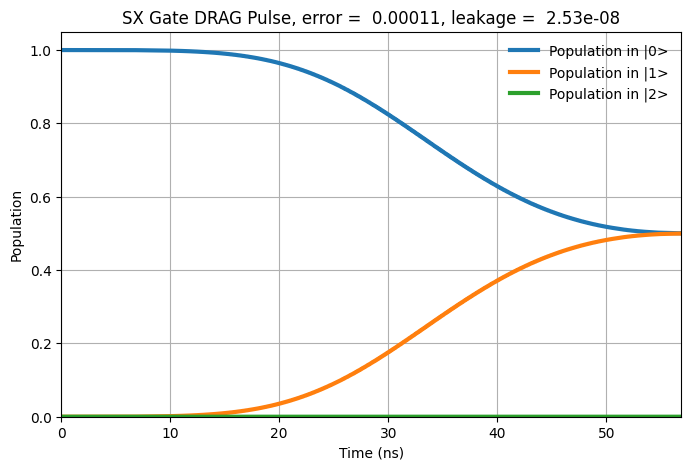

In [76]:
ground_state = Statevector([1.,0,0])
solSX = ex.solve_dynamics(ground_state, ex.SX_pulse)
plt.title(f'SX Gate DRAG Pulse, error = {ex.SX_results.fun: .3g}, leakage = {solSX.y[-1].probabilities()[2]: .3g}')

X Gate

In [77]:
#X_results, X_pulse = ex.opt_RX(np.pi)
ex.X_results

 message: Solution found.
 success: True
  status: 0
     fun: 0.001747970547363531
       x: 0.326413939663896
     nit: 13
    nfev: 13

Text(0.5, 1.0, 'X Gate DRAG Pulse, error =  0.00175, leakage =  2.04e-07')

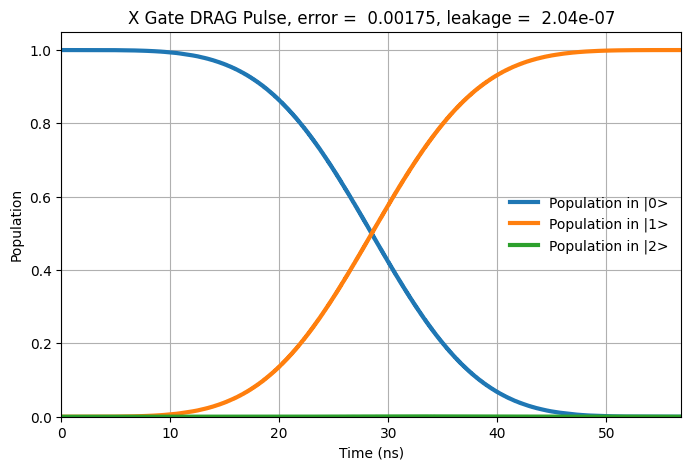

In [78]:
solX = ex.solve_dynamics(ground_state, ex.X_pulse)
plt.title(f'X Gate DRAG Pulse, error = {ex.X_results.fun: .3g}, leakage = {solX.y[-1].probabilities()[2]: .3g}')

Hadamard Gate

In [55]:
#Heatmap plot code
from mpl_toolkits.axes_grid1 import AxesGrid
def heatmap2d(arr: np.ndarray):
    # define axes grid
    fig = plt.figure(frameon=False,figsize=(12, 8))
    fig.subplots_adjust(top=0.95)
    grid = AxesGrid(
        fig, 111, 
        nrows_ncols=(1, 2),
        axes_pad=0.5,
        cbar_mode='each',
        cbar_location='right',
        cbar_pad=0.1
    )   
    # plot 
    real_image = grid[0].imshow(np.real(arr), cmap='plasma')
    grid[0].set_title("Real Part of matrix, $\Re{(M)}$", fontsize=20)
    imag_image = grid[1].imshow(np.imag(arr), cmap='plasma')
    grid[1].set_title("Imaginary Part of matrix, $\Im{(M)}$", fontsize=20)
    cbar = grid.cbar_axes[0].colorbar(real_image)
    cbar = grid.cbar_axes[1].colorbar(imag_image)
    plt.show()

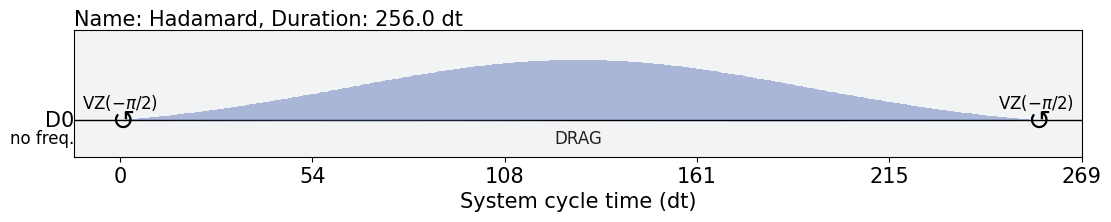

In [79]:
H_gate = ex.hadamard()
H_gate.draw()

In [53]:
solH = ex.solve_dynamics(jnp.eye(3, dtype=complex), H_gate, plot_pops=False, JAXmethod=True)
H_fidelity = Transmon.fidelity(Transmon.ideal_H(), solH.y[-1])
H_fidelity.item()

0.05555869174955162

In [52]:
H_fidelity.item()

0.05555869174955162

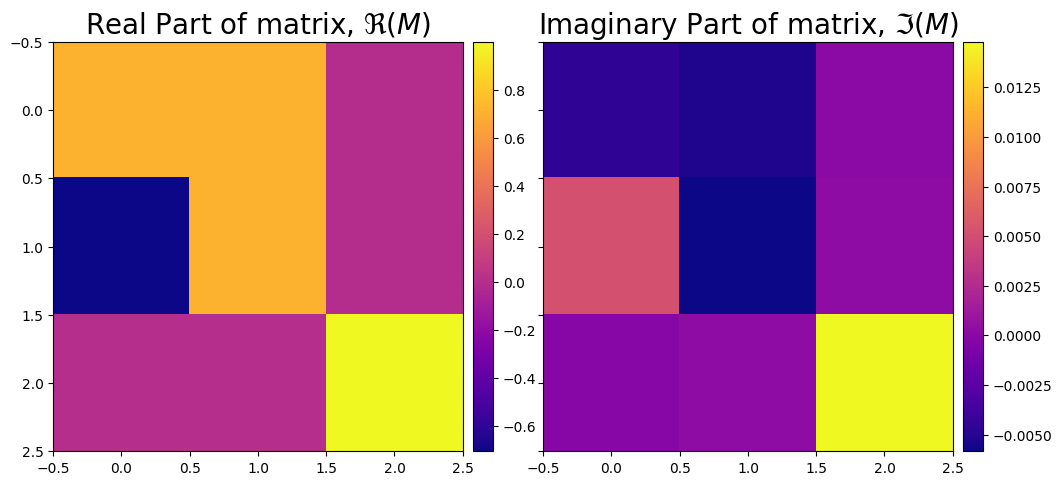

In [56]:
heatmap2d(solH.y[-1])

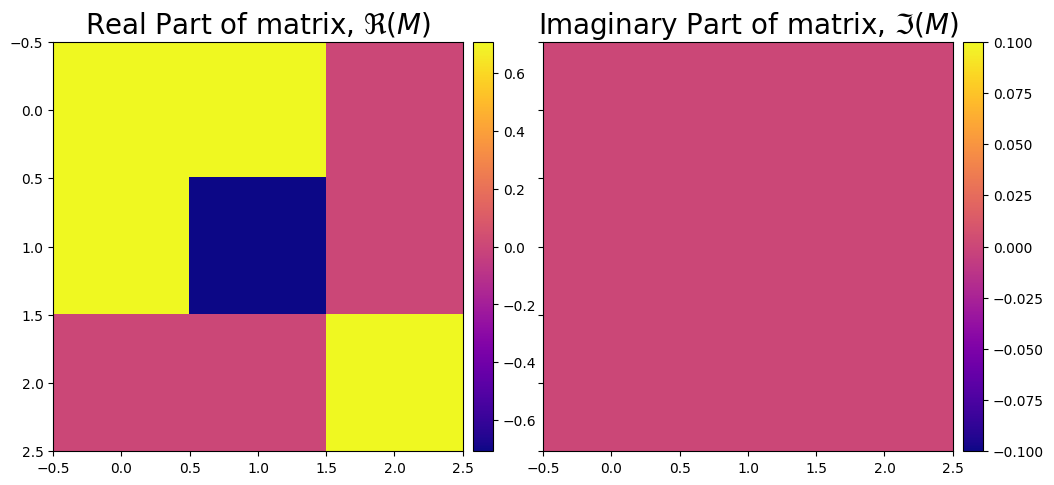

In [57]:
heatmap2d(Transmon.ideal_H())